# <font color = 'indianred'>**Token Classification with DistilBert- NER** </font>




## Outline
1. **Setting up the Environment**: Installing necessary libraries and setting up paths.
2. **Creating Huggingface Dataset for Custom Dataset**: Understanding the structure and content of the dataset.

3. **Data Preprocessing**: Techniques to prepare the data for training, including handling different data splits and tokenization
4. **Training the Model**: Feeding data and adjusting weights.
5. **Inference**: Evaluate model on test set and making predictions.



# <font color = 'indianred'> **Setting up the Environment** </font>



In [ ]:
 # CHANGE FOLDERS AS PER YOUR SETUP
from pathlib import Path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    !pip install datasets transformers evaluate wandb accelerate seqeval -U -qq
    base_folder = Path("/content/drive/MyDrive/Google colab NLP")



from transformers import AutoConfig, AutoModelForTokenClassification, AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoTokenizer, DataCollatorForTokenClassification, pipeline
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel, Sequence
import evaluate


import wandb

import numpy as np
# from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import textwrap



Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# CHANGE FOLDERS TO WHERE YOU WANT TO SAVE DATA AND MODELS
data_folder = base_folder
model_folder = base_folder
model_folder.mkdir(exist_ok=True)
data_folder.mkdir(exist_ok=True)

In [ ]:
def print_wrap(text, d):
    # If the text is a list, convert it to a string
    if isinstance(text, list):
        # Convert None values to a default string (e.g., "None" or an empty string)
        text = ' '.join(str(item) if item is not None else "None" for item in text)

    # Wrap the text to limit the width to 'd'
    wrapped_text = textwrap.fill(text, width=d)

    # Print the wrapped text
    print(wrapped_text)


# <font color = 'indianred'> **Exploring and Understanding Dataset**

## <font color = 'indianred'> **conll2003 Dataset**</font>



## <font color = 'indianred'> **Load Data set**
    


In [ ]:
conll_dataset = load_dataset('conll2003')

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [ ]:
conll_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

## <font color = 'indianred'> **Understanding your data**

In [ ]:
print(conll_dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})


## <font color = 'indianred'> **Understanding the datatype of columns**


In [ ]:
conll_dataset['train'].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'pos_tags': Sequence(feature=ClassLabel(names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], id=None), length=-1, id=None),
 'chunk_tags': Sequence(feature=ClassLabel(names=['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP', 'I-UCP', 'B-VP', 'I-VP'], id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)}

In [ ]:
conll_dataset['test'].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'pos_tags': Sequence(feature=ClassLabel(names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], id=None), length=-1, id=None),
 'chunk_tags': Sequence(feature=ClassLabel(names=['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP', 'I-UCP', 'B-VP', 'I-VP'], id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)}

## <font color = 'indianred'> **Acess indivdual element** </font>


In [ ]:
# get the first example of the dataset
conll_dataset['train'][0]


{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [ ]:
print_wrap(conll_dataset['train']['tokens'][0], 80)

EU rejects German call to boycott British lamb .


In [ ]:
print_wrap(conll_dataset['train']['ner_tags'][0], 80)

3 0 7 0 0 0 7 0 0


## <font color = 'indianred'> **Exploratory Data Analysis (EDA)**

### <font color = 'indianred'> **Change dataset format to Pandas**  </font>


In [ ]:
# Set the format to Pandas
conll_dataset.set_format(type='pandas')

In [ ]:
# get all rows the dataset
df = conll_dataset['train'][:]


In [ ]:
df.head()

,id,tokens,pos_tags,chunk_tags,ner_tags
0,0,"[EU, rejects, German, call, to, boycott, Briti...","[22, 42, 16, 21, 35, 37, 16, 21, 7]","[11, 21, 11, 12, 21, 22, 11, 12, 0]","[3, 0, 7, 0, 0, 0, 7, 0, 0]"
1,1,"[Peter, Blackburn]","[22, 22]","[11, 12]","[1, 2]"
2,2,"[BRUSSELS, 1996-08-22]","[22, 11]","[11, 12]","[5, 0]"
3,3,"[The, European, Commission, said, on, Thursday...","[12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 3...","[11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 1...","[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ..."
4,4,"[Germany, 's, representative, to, the, Europea...","[22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 2...","[11, 11, 12, 13, 11, 12, 12, 11, 12, 12, 12, 1...","[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14041 entries, 0 to 14040
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          14041 non-null  object
 1   tokens      14041 non-null  object
 2   pos_tags    14041 non-null  object
 3   chunk_tags  14041 non-null  object
 4   ner_tags    14041 non-null  object
dtypes: object(5)
memory usage: 548.6+ KB


### <font color = 'indianred'> **Visualize distribution of class labels** </font>
It is important to undetrstand the distribution of the class labels to check if there is any imbalance among the categories.

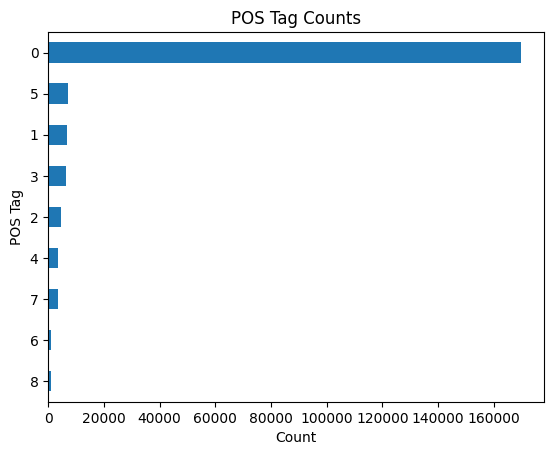

In [ ]:
# check distribution of class labels in the dataset
# Flatten the lists in df['tags']
all_tags = [tag for sublist in df['ner_tags'] for tag in sublist]

# Convert to a pandas Series and count occurrences of each tag
tag_counts = pd.Series(all_tags).value_counts(ascending=True)

# Plot the counts
tag_counts.plot.barh()
plt.xlabel('Count')
plt.ylabel('POS Tag')
plt.title('POS Tag Counts')
plt.show()

**Conclusions:**



### <font color = 'indianred'> **Check length of the reviews** </font>


In [ ]:
# Calculate words per review
df['words_per_sentence'] = df['tokens'].apply(len)


In [ ]:
df.head()

,id,tokens,pos_tags,chunk_tags,ner_tags,words_per_sentence
0,0,"[EU, rejects, German, call, to, boycott, Briti...","[22, 42, 16, 21, 35, 37, 16, 21, 7]","[11, 21, 11, 12, 21, 22, 11, 12, 0]","[3, 0, 7, 0, 0, 0, 7, 0, 0]",9
1,1,"[Peter, Blackburn]","[22, 22]","[11, 12]","[1, 2]",2
2,2,"[BRUSSELS, 1996-08-22]","[22, 11]","[11, 12]","[5, 0]",2
3,3,"[The, European, Commission, said, on, Thursday...","[12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 3...","[11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 1...","[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ...",30
4,4,"[Germany, 's, representative, to, the, Europea...","[22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 2...","[11, 11, 12, 13, 11, 12, 12, 11, 12, 12, 12, 1...","[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ...",31


#### <font color = 'indianred'> **Plot the distribution of review length** </font>

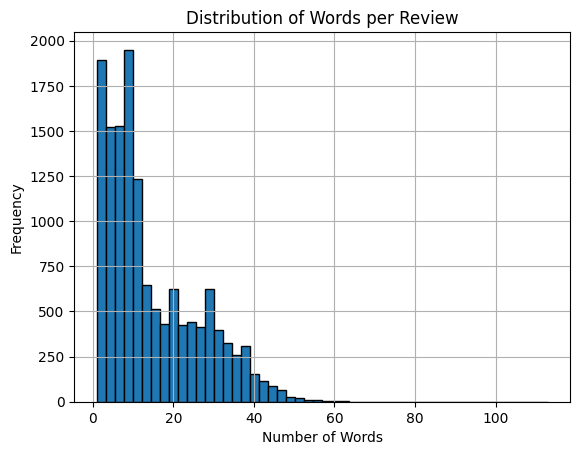

In [ ]:
# Plot a histogram of the 'words_per_review' column
df['words_per_sentence'].hist(bins=50, edgecolor='black')

# Adding labels and a title for clarity
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Words per Review')

# Display the plot
plt.show()


In [ ]:
# The model we are going to use has token (subwords) limit of 512.
# Let us check how many reviews has more than 500 words

count = (df['words_per_sentence'] > 500).sum()
print(f"Number of reviews with more than 400 words: {count}")


Number of reviews with more than 400 words: 0


In [ ]:
# count the rows that do not have any text
count = (df['words_per_sentence'] ==0).sum()
print(f"Number of reviews with no text words: {count}")

Number of reviews with no text words: 0


In [ ]:
# check the rows that have one word
count = (df['words_per_sentence'] <2).sum()
print(f"Number of reviews with less than 1 word: {count}")

Number of reviews with less than 1 word: 179


In [ ]:
df[df['words_per_sentence'] <2]

,id,tokens,pos_tags,chunk_tags,ner_tags,words_per_sentence
11,11,[.],[7],[0],[0],1
200,200,[THAWRA],[38],[11],[3],1
203,203,[IRAQ],[21],[11],[5],1
209,209,[AN-NAHAR],[22],[11],[3],1
212,212,[AS-SAFIR],[22],[11],[3],1
...,...,...,...,...,...,...
13751,13751,[Jul-18.Jul],[21],[11],[0],1
13855,13855,[GDP],[22],[11],[0],1
13879,13879,[ABC],[22],[11],[3],1
13883,13883,[EXPANSION],[21],[11],[3],1


<Axes: >

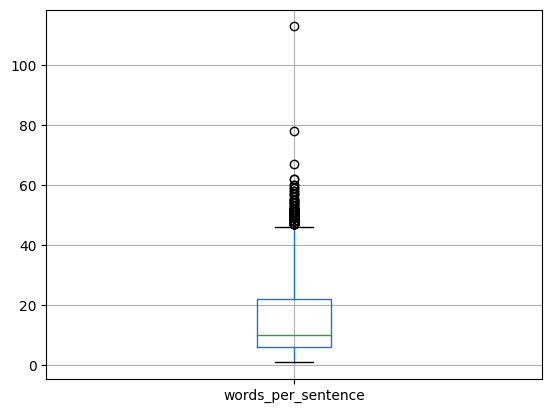

In [ ]:
# distribution of number of words for each class label
df.boxplot('words_per_sentence')


### <font color = 'indianred'> **Reset dataset format** </font>


In [ ]:
# reset the format back to huggingface dataset
conll_dataset.reset_format()


In [ ]:
conll_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [ ]:
conll_dataset['train']['tokens'][13907]

['*']

# <font color = 'indianred'> **Data Pre-processing**</font>

### <font color = 'indianred'> **Create small subset for experimentation** </font>


In [ ]:
train_split_small = conll_dataset['train'].shuffle(seed=42).select(range(5000))
val_split_small = conll_dataset['validation'].shuffle(seed=42).select(range(1000))
test_split_small = conll_dataset['test'].shuffle(seed=42).select(range(1000))

In [ ]:
# combine train, val splits into one dataset
train_val_subset = DatasetDict({'train': train_split_small, 'val': val_split_small})

# create test dataset from test split
test_subset= DatasetDict({'test': test_split_small})



In [ ]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 5000
    })
    val: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 1000
    })
})

In [ ]:
test_subset

DatasetDict({
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 1000
    })
})

### <font color = 'indianred'> **Map Targets to integers** </font>

In [ ]:
class_names = conll_dataset['train'].features['ner_tags'].feature.names

In [ ]:
class_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [ ]:
id2label = {}
for id_, label_ in enumerate(class_names):
    id2label[str(id_)] = label_
id2label

{'0': 'O',
 '1': 'B-PER',
 '2': 'I-PER',
 '3': 'B-ORG',
 '4': 'I-ORG',
 '5': 'B-LOC',
 '6': 'I-LOC',
 '7': 'B-MISC',
 '8': 'I-MISC'}

In [ ]:
label2id = {}
for id_, label_ in enumerate(class_names):
    label2id[label_] = id_
label2id

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6,
 'B-MISC': 7,
 'I-MISC': 8}

## <font color = 'indianred'> **Tokenization**</font>



In [ ]:
# Define a checkpoint for the DistilBERT model with an uncased vocabulary.
# Instantiate the tokenizer for this model using the specified checkpoint.
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

###  <font color = 'indianred'> **Understanding pre-trained Tokenizer**
- We also need to keep track of word ids so that we can align labels with tokens


In [ ]:
idx = 0
encoded_text = tokenizer(train_val_subset['train']['tokens'][idx], is_split_into_words=True) ####### NEW ############

In [ ]:
encoded_text

{'input_ids': [101, 1000, 4445, 1996, 2120, 21633, 1006, 13157, 1007, 4496, 1996, 13009, 15048, 2000, 22590, 2019, 2137, 6926, 1010, 1000, 2002, 6626, 1010, 1999, 2019, 20658, 4431, 2000, 2010, 4469, 20562, 2000, 2762, 2013, 5842, 1012, 1000, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print_wrap(tokens, 80)

[CLS] " neither the national socialists ( nazis ) nor the communists dared to
kidnap an american citizen , " he shouted , in an oblique reference to his extra
##dition to germany from denmark . " [SEP]


In [ ]:
print_wrap(tokenizer.convert_tokens_to_string(tokens),80)

[CLS] " neither the national socialists ( nazis ) nor the communists dared to
kidnap an american citizen, " he shouted, in an oblique reference to his
extradition to germany from denmark. " [SEP]


In [ ]:
print_wrap(train_val_subset['train']['tokens'][idx], 80)

" Neither the National Socialists ( Nazis ) nor the communists dared to kidnap
an American citizen , " he shouted , in an oblique reference to his extradition
to Germany from Denmark . "


In [ ]:
print_wrap(encoded_text.word_ids(), 80)

None 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
28 28 29 30 31 32 33 34 None


###  <font color = 'indianred'> **Create function for Tokenizer**

In [ ]:
['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

def align_targets(labels, word_ids):
    """
    Aligns the target labels based on word IDs, ensuring that words split into multiple tokens
    correctly transition from B- tags to I- tags.

    Args:
    - labels (list): A list of labels to be aligned.
    - word_ids (list): A list of word IDs where each ID corresponds to a label in the 'labels' list.
                      If an ID is 'None', it means the word does not have a corresponding label.

    Returns:
    - list: A list of aligned labels. Special tokens have label -100.
            For words split across tokens, B- tags are transitioned to I- tags for subsequent tokens of the same word.
    """

    # Dictionary mapping from B- tag indices to corresponding I- tag indices
    begin2inside = {1:2, 3:4, 5:6, 7:8}

    aligned_labels = []
    last_id = None

    for word_id in word_ids:
        # Check if the current token is a special token (like [CLS], [SEP] etc.)
        if word_id is None:
            label = -100
        # Check if it's a new word (i.e., not part of the previous word)
        elif word_id != last_id:
            label = labels[word_id]
        else:  # Token is part of the same word as the previous token
            label = labels[word_id]
            # If the label starts with a B-, we transition it to the corresponding I- tag
            if label in begin2inside:
                label = begin2inside[label]

        # Add the label to the aligned list
        aligned_labels.append(label)

        # Update the last_id for the next iteration
        last_id = word_id

    return aligned_labels

In [ ]:
# check the function
word_ids = encoded_text.word_ids()
labels = train_val_subset['train']['ner_tags'][idx]
aligned_labels = align_targets(labels, word_ids)
print('word_ids', word_ids[0:15])
print('labels:',labels[0:15])
print('aligned_labels',aligned_labels[0:15])
print(len(word_ids))
print(len(labels))
print(len(aligned_labels))



word_ids [None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
labels: [0, 0, 0, 7, 8, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0]
aligned_labels [-100, 0, 0, 0, 7, 8, 0, 7, 0, 0, 0, 0, 0, 0, 0]
38
35
38


In [ ]:
def tokenize_fn(batch):
    """
    Tokenizes a batch of sequences and aligns the target labels with the tokenized outputs.

    Args:
    - batch (dict): A dictionary containing:
        * 'tokens': A list of lists where each inner list contains tokens of a sequence.
        * 'tags': A list of lists where each inner list contains POS tags corresponding to the 'tokens'.

    Returns:
    - dict: A dictionary containing tokenized inputs and their corresponding aligned labels.
    """

    # Tokenize the 'tokens' from the batch. This returns various fields like 'input_ids', 'attention_mask', etc.
    # 'is_split_into_words=True' indicates the input is already tokenized into words.
    # 'truncation=True' ensures sequences longer than the model's max length are truncated.
    tokenized_inputs = tokenizer(batch['tokens'], truncation=True, is_split_into_words=True)

    # Extract the original labels/tags from the batch.
    labels_batch = batch['ner_tags']

    # This list will store the labels aligned with the tokenized input.
    aligned_labels_batch = []

    # Iterate over each example in the batch.
    for i, labels in enumerate(labels_batch):
        # Obtain the word IDs for the tokenized example. This helps in aligning the original labels with the tokens.
        word_ids = tokenized_inputs.word_ids(i)

        # Align the original labels with the tokenized example and append to the aligned_labels_batch list.
        aligned_labels_batch.append(align_targets(labels, word_ids))

    # The HuggingFace trainer expects the labels for token classification tasks to be under the key 'labels'.
    # Store the aligned labels in the 'labels' key of the tokenized_inputs dictionary.
    tokenized_inputs['labels'] = aligned_labels_batch

    return tokenized_inputs



###  <font color = 'indianred'> **Use map function to apply tokenization to all splits**

In [ ]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 5000
    })
    val: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 1000
    })
})

In [ ]:
# Map the tokenize_fn function over the entire train_val_subset dataset in batches.
# This will tokenize the text data in each batch and return a new dataset with tokenized data.
tokenized_dataset = train_val_subset.map(tokenize_fn, batched=True)


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 5000
    })
    val: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
})

In [ ]:
tokenized_dataset['train'].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'pos_tags': Sequence(feature=ClassLabel(names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], id=None), length=-1, id=None),
 'chunk_tags': Sequence(feature=ClassLabel(names=['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP', 'I-UCP', 'B-VP', 'I-VP'], id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None),
 'input_ids': Sequence(feature=Value(dtype='int32'

We can see that tokenization step has added three new columns ('input_ids', 'token_type_ids', 'attention_mask') to the dataset

In [ ]:
tokenized_dataset = tokenized_dataset.remove_columns(['tokens', 'ner_tags', 'pos_tags','chunk_tags', 'id'])

In [ ]:
tokenized_dataset.set_format(type='torch')

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 5000
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
})

In [ ]:
tokenized_dataset['train'].features

{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [ ]:
print(len(tokenized_dataset["train"]["input_ids"][2]))
print(len(tokenized_dataset["train"]["input_ids"][1]))

12
8


The varying lengths in the dataset indicate that padding has not been applied yet. Instead of padding the entire dataset, we prefer processing small batches during training. Padding is done selectively for each batch based on the maximum length in the batch. We will discuss this in more detail in a later section of this notebook.

#  <font color = 'indianred'> **Model Training**

##  <font color = 'indianred'> **Model Config File**

###  <font color = 'indianred'> **Download config file of pre-trained Model**</font>



In [ ]:
# Load the configuration associated with the specified checkpoint (e.g., DistilBERT model configuration).
# This configuration contains details about the model architecture and settings.
# use Autoconfig class
config = AutoConfig.from_pretrained(checkpoint)

In [ ]:
config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.34.1",
  "vocab_size": 30522
}

###  <font color = 'indianred'> **Modify Configuration File**</font>
- We need to modify configuration fie to add ids to  label and label to ids mapping
- Adding id2label and label2id to the configuration file provides a consistent, interpretable, and user-friendly way to handle model outputs.

In [ ]:
config.id2label = id2label
config.label2id = label2id

In [ ]:
config


DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "O",
    "1": "B-PER",
    "2": "I-PER",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-LOC",
    "6": "I-LOC",
    "7": "B-MISC",
    "8": "I-MISC"
  },
  "initializer_range": 0.02,
  "label2id": {
    "B-LOC": 5,
    "B-MISC": 7,
    "B-ORG": 3,
    "B-PER": 1,
    "I-LOC": 6,
    "I-MISC": 8,
    "I-ORG": 4,
    "I-PER": 2,
    "O": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.34.1",
  "vocab_size": 30522
}

##  <font color = 'indianred'> **Download pre-trained model**

In [ ]:
# Instantiate a model for sequence classification using the specified checkpoint.
# The provided configuration (config) ensures the model aligns with the structure and settings of the original checkpoint.
# Use AutoModelForSequenceClassification
# Pass the checkpoint and config
model = AutoModelForTokenClassification.from_pretrained(checkpoint, config=config)


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "O",
    "1": "B-PER",
    "2": "I-PER",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-LOC",
    "6": "I-LOC",
    "7": "B-MISC",
    "8": "I-MISC"
  },
  "initializer_range": 0.02,
  "label2id": {
    "B-LOC": 5,
    "B-MISC": 7,
    "B-ORG": 3,
    "B-PER": 1,
    "I-LOC": 6,
    "I-MISC": 8,
    "I-ORG": 4,
    "I-PER": 2,
    "O": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.34.1",
  "vocab_size": 30522
}

## <font color = 'indianred'> **Model Input/Collate Function** </font>

In [ ]:
data_collator =  DataCollatorForTokenClassification(tokenizer = tokenizer,
                                                  padding=True,
                                                  label_pad_token_id=-100,
                                                  return_tensors='pt')

In [ ]:
features = [tokenized_dataset["train"][i] for i in range(2)]

In [ ]:
features

[{'input_ids': tensor([  101,  1000,  4445,  1996,  2120, 21633,  1006, 13157,  1007,  4496,
           1996, 13009, 15048,  2000, 22590,  2019,  2137,  6926,  1010,  1000,
           2002,  6626,  1010,  1999,  2019, 20658,  4431,  2000,  2010,  4469,
          20562,  2000,  2762,  2013,  5842,  1012,  1000,   102]),
  'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'labels': tensor([-100,    0,    0,    0,    7,    8,    0,    7,    0,    0,    0,    0,
             0,    0,    0,    0,    7,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    5,    0,    5,    0,
             0, -100])},
 {'input_ids': tensor([  101, 25317,  2727,  1011,  5511,  1011,  2570,   102]),
  'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1]),
  'labels': tensor([-100,    5,    0,    0,    0,    0,    0, -100])}]

In [ ]:
model_input = data_collator(features)
model_input.keys()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


dict_keys(['input_ids', 'attention_mask', 'labels'])

In [ ]:
print(model_input.input_ids[0][0:10])
print(model_input.input_ids[0][-20:])
print(model_input.input_ids[1][0:10])
print(model_input.input_ids[1][-20:])

tensor([  101,  1000,  4445,  1996,  2120, 21633,  1006, 13157,  1007,  4496])
tensor([ 1010,  1000,  2002,  6626,  1010,  1999,  2019, 20658,  4431,  2000,
         2010,  4469, 20562,  2000,  2762,  2013,  5842,  1012,  1000,   102])
tensor([  101, 25317,  2727,  1011,  5511,  1011,  2570,   102,     0,     0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
print(model_input.attention_mask[0][-20:])
print(model_input.attention_mask[1][-20:])

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
print(tokenizer.convert_ids_to_tokens(model_input.input_ids[0][0:10]))

['[CLS]', '"', 'neither', 'the', 'national', 'socialists', '(', 'nazis', ')', 'nor']


In [ ]:
print(tokenizer.convert_ids_to_tokens(model_input.input_ids[0][-10:]))

['his', 'extra', '##dition', 'to', 'germany', 'from', 'denmark', '.', '"', '[SEP]']


In [ ]:
print(tokenizer.convert_ids_to_tokens(model_input.input_ids[1][0:10]))

['[CLS]', 'tunis', '1996', '-', '08', '-', '22', '[SEP]', '[PAD]', '[PAD]']


In [ ]:
print(tokenizer.convert_ids_to_tokens(model_input.input_ids[1][-10:]))

['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


##  <font color = 'indianred'> **Understanding Model Output**

In [ ]:
# model output
model=model.to(device=0)
model_input= model_input.to(device=0)


In [ ]:
model_input['labels'].shape

torch.Size([2, 38])

In [ ]:
model_input['input_ids'].shape

torch.Size([2, 38])

In [ ]:
model.train()
model_output = model(**model_input)

In [ ]:
# keys in model output
model_output.keys()

odict_keys(['loss', 'logits'])

In [ ]:
# let us look at logits
model_output.logits


tensor([[[ 0.2081,  0.1858,  0.0092, -0.2767, -0.2180,  0.1369,  0.6606,
          -0.0971,  0.0970],
         [ 0.3764,  0.3100,  0.1267, -0.4443, -0.0376,  0.1587,  0.5830,
           0.0451,  0.0636],
         [ 0.2337,  0.1118,  0.2150, -0.2060, -0.0770,  0.1202,  0.4369,
           0.0244,  0.2275],
         [ 0.0078, -0.0264,  0.0259, -0.0424,  0.1329, -0.3944,  0.1650,
          -0.0637,  0.0380],
         [ 0.2179,  0.3129,  0.2568, -0.3085, -0.0602,  0.2046,  0.5601,
          -0.3530,  0.2387],
         [-0.0798, -0.0952,  0.0038, -0.0584, -0.3357, -0.0591,  0.4481,
           0.0085,  0.1102],
         [ 0.2437, -0.0378,  0.2928, -0.0900, -0.1393,  0.0120,  0.5889,
          -0.1386,  0.0915],
         [-0.0209,  0.0777, -0.2469, -0.2308, -0.1798,  0.0958,  0.3906,
           0.0260,  0.0110],
         [ 0.0088, -0.0148, -0.5199,  0.2560, -0.3943, -0.2051,  0.0490,
          -0.3610,  0.0610],
         [ 0.4005, -0.1932,  0.0847, -0.1852, -0.0038,  0.0059,  0.3813,
         

In [ ]:
model_output.logits.shape

torch.Size([2, 38, 9])

In [ ]:
model_output.loss

tensor(2.0850, device='cuda:0', grad_fn=<NllLossBackward0>)

##  <font color = 'indianred'> **Evaluation metric(s)** </font>

### <font color = 'indianred'> **Function to compute metric** </font>



In [ ]:
# Understanding and checking the function
true_labels = np.array([[-100, 0, 0, 1, 2, 1,-100], [-100, 0, 2, 1, 0, 1,-100]])
logits = np.array([

    [[0.8, 0.1, 0.1],
    [0.8, 0.1, 0.1],
    [0.8, 0.1, 0.1],
    [0.1, 0.8, 0.1],
    [0.1, 0.8, 0.1],
    [0.1, 0.8, 0.1],
    [0.8, 0.1, 0.1]],

    [[0.8, 0.1, 0.1],
    [0.8, 0.1, 0.1],
    [0.8, 0.1, 0.1],
    [0.1, 0.8, 0.1],
    [0.1, 0.8, 0.1],
    [0.1, 0.8, 0.1],
    [0.1, 0.8, 0.1]]

])

In [ ]:
predicted_indices = np.argmax(logits, axis=-1)
predicted_indices

array([[0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 1, 1, 1, 1]])

In [ ]:
string_true_labels = [[class_names[label_id] for label_id in sequence if label_id != -100] for sequence in true_labels]

# Convert predicted indices to their string representation, but only for tokens where the true label isn't -100
string_predictions = [
    [class_names[pred_id] for pred_id, true_label_id in zip(pred_sequence, true_sequence) if true_label_id != -100]
    for pred_sequence, true_sequence in zip(predicted_indices, true_labels)
]

In [ ]:
print(string_predictions)
print(string_true_labels)

[['O', 'O', 'B-PER', 'B-PER', 'B-PER'], ['O', 'O', 'B-PER', 'B-PER', 'B-PER']]
[['O', 'O', 'B-PER', 'I-PER', 'B-PER'], ['O', 'I-PER', 'B-PER', 'O', 'B-PER']]


In [ ]:
metric = evaluate.load("seqeval")

In [ ]:
metric??

In [ ]:
metric.compute(predictions=string_predictions, references=string_true_labels)

{'PER': {'precision': 0.5,
  'recall': 0.6,
  'f1': 0.5454545454545454,
  'number': 5},
 'overall_precision': 0.5,
 'overall_recall': 0.6,
 'overall_f1': 0.5454545454545454,
 'overall_accuracy': 0.7}

In [ ]:
seqeval_metric = evaluate.load('seqeval')
def compute_metrics(logits_and_labels):
    """
    Compute sequence tagging metrics using the seqeval metric.

    Args:
    - logits_and_labels (tuple): A tuple containing model logits and true labels.

    Returns:
    - dict: A dictionary containing precision, recall, f1-score, and accuracy.
    """

    # Separate logits and labels from the input tuple
    logits, true_labels = logits_and_labels

    # Obtain predicted label indices by selecting the label with the highest logit value for each token
    predicted_indices = np.argmax(logits, axis=-1)  # Shape: (batch_size, sequence_length)

    # Convert label indices to their string representation, ignoring special tokens (label index = -100)
    string_true_labels = [[class_names[label_id] for label_id in sequence if label_id != -100] for sequence in true_labels]

    # Convert predicted indices to their string representation, but only for tokens where the true label isn't -100
    string_predictions = [
        [class_names[pred_id] for pred_id, true_label_id in zip(pred_sequence, true_sequence) if true_label_id != -100]
        for pred_sequence, true_sequence in zip(predicted_indices, true_labels)
    ]

    # Compute the metrics using seqeval
    metrics_results = seqeval_metric.compute(predictions=string_predictions, references=string_true_labels)

    return {
        'precision': metrics_results['overall_precision'],
        'recall': metrics_results['overall_recall'],
        'f1': metrics_results['overall_f1'],
        'accuracy': metrics_results['overall_accuracy']
    }


In [ ]:
compute_metrics((logits, true_labels))

{'precision': 0.5, 'recall': 0.6, 'f1': 0.5454545454545454, 'accuracy': 0.7}

## <font color = 'indianred'> **Set up Logger for experiments**</font>

In [ ]:
# YOU WILL NEED TO CREATE AN ACCOUNT FOR WANDB
# It may provide a link for token , copy paste the token following instructions
# setup wandb
wandb.login()  # you will need to create wandb account first
# Set project name for logging
%env WANDB_PROJECT = nlp_course_fall_2023-ner

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_PROJECT=nlp_course_fall_2023-ner


## <font color = 'indianred'> **Hyperparameters and Checkpointing**</font>

In [ ]:
# Define the directory where model checkpoints will be saved
model_folder = base_folder / "models"/"nlp_fall_2023/pos/dbert"
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=16,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="accuracy",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= 'ner_exp1',  # Experiment name for Weights & Biases
)


##  <font color = 'indianred'> **Initialize Trainer**</font>

In [ ]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)


##  <font color = 'indianred'> **Start Training**

In [ ]:
trainer.data_collator

DataCollatorForTokenClassification(tokenizer=DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}, padding=True, max_length=None, pad_to_multiple_of=None, label_pad_tok

In [ ]:
trainer.train()  # start training


wandb: Currently logged in as: anurag96. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,1.281400,0.792266,0.000000,0.000000,0.000000,0.792906
40,0.677200,0.519755,0.124000,0.017280,0.030333,0.816904
60,0.479500,0.375395,0.477807,0.510033,0.493394,0.883743
80,0.348600,0.284482,0.561151,0.608696,0.583957,0.926530
100,0.274600,0.221429,0.617995,0.670011,0.642953,0.939424
120,0.232000,0.184180,0.642310,0.700669,0.670221,0.945108
140,0.212100,0.160319,0.719353,0.768673,0.743196,0.954897
160,0.213900,0.145041,0.760720,0.801003,0.780342,0.959371
180,0.171600,0.133424,0.751287,0.813266,0.781049,0.963107
200,0.152900,0.122528,0.785526,0.828874,0.806618,0.965212


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are i

TrainOutput(global_step=626, training_loss=0.200363602072667, metrics={'train_runtime': 278.6938, 'train_samples_per_second': 35.882, 'train_steps_per_second': 2.246, 'total_flos': 121120544570256.0, 'train_loss': 0.200363602072667, 'epoch': 2.0})

## <font color = 'indianred'> **Evaluation**


### <font color = 'indianred'> **Check performance on validation set**</font>


In [ ]:
# Evaluate the trained model on the tokenized validation dataset.
# This will provide metrics like loss, accuracy, etc. based on the model's performance on the validation set.
trainer.evaluate(tokenized_dataset["val"])


{'eval_loss': 0.07989152520895004,
 'eval_precision': 0.8464796188459502,
 'eval_recall': 0.8913043478260869,
 'eval_f1': 0.8683138745587836,
 'eval_accuracy': 0.9782643018788485,
 'eval_runtime': 2.1009,
 'eval_samples_per_second': 475.989,
 'eval_steps_per_second': 29.987,
 'epoch': 2.0}

###  <font color = 'indianred'> **Check Confusion Matrix**</font>




In [ ]:
# Use the trainer to generate predictions on the tokenized validation dataset.
# The resulting object, valid_output, will contain the model's logits (raw prediction scores) for each input in the validation set.
valid_output = trainer.predict(tokenized_dataset["val"])


In [ ]:
# Retrieve the named fields (attributes) of the valid_output object.
# This helps understand the structure of the prediction output and the available information it contains.
valid_output._fields



('predictions', 'label_ids', 'metrics')

In [ ]:
# Check and print the shape of the predictions and label_ids from the valid_output object.
# This provides insight into the dimensions of the predicted outputs and the true labels for the validation set.
print(valid_output.predictions.shape)
print(valid_output.label_ids.shape)




(1000, 146, 9)
(1000, 146)


In [ ]:
# Convert the logits (raw prediction scores) from the valid_output object into class predictions.
# For each input, pick the class with the highest logit as the predicted class.
# Also, extract the true label IDs from valid_output and store them as an array for further analysis.
valid_predictions = np.argmax(valid_output.predictions, axis=2)
valid_labels = np.array(valid_output.label_ids)

# 2. Filter out any tokens with label -100 (typically used for padding or special tokens)
mask = valid_labels != -100
filtered_predictions = valid_predictions[mask]
filtered_labels = valid_labels[mask]

In [ ]:
class_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

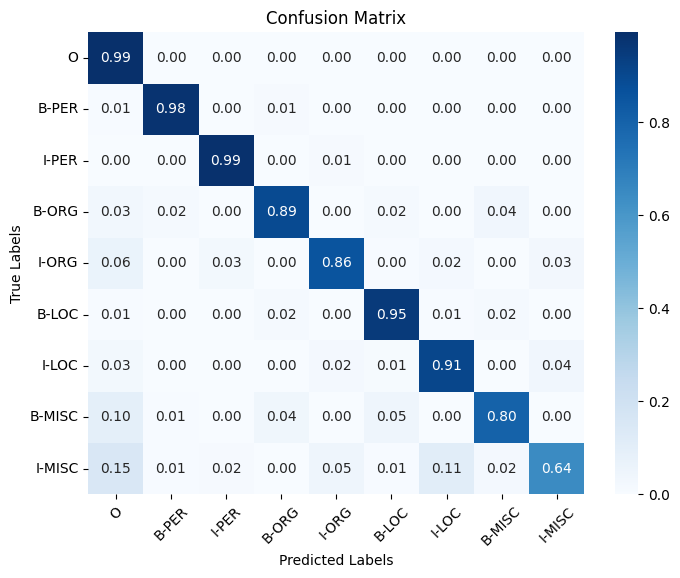

In [ ]:

#  Generate the confusion matrix
cm = confusion_matrix(filtered_labels, filtered_predictions,normalize='true')

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
ax= sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
# Ensure x-labels are vertical
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Ensure y-labels are horizontal
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Log the confusion matrix to the Weights & Biases (Wandb) platform for monitoring and visualization.
# This allows for tracking the model's classification performance across different runs or iterations.

# log the Confusion Matrix to Wandb
wandb.log({
    "conf_mat": wandb.plot.confusion_matrix(
        preds=filtered_predictions,        # Model's predicted class labels.
        y_true=filtered_labels,      # Actual labels from the validation set.
        class_names=class_names   # Custom class names for display in the confusion matrix.
    )
})



In [ ]:
wandb.finish()


eval/accuracy,▁▂▄▆▇▇▇▇▇███████████████████████
eval/f1,▁▁▅▆▆▆▇▇▇▇▇█████████████████████
eval/loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/precision,▁▂▅▆▆▆▇▇▇▇▇▇████████████████████
eval/recall,▁▁▅▆▆▆▇▇▇███████████████████████
eval/runtime,▃▁▁▆▄▁▂▂▂▄▂▄▂▄▁▂▂▂▅▂▃▂▄▃▅▂█▂▄▁▄▂
eval/samples_per_second,▅██▂▄█▆▆▆▄▆▄▆▄█▆▇▆▃▇▄▆▄▅▃▆▁▆▃▇▃▇
eval/steps_per_second,▅██▂▄█▆▆▆▄▆▄▆▄█▆▇▆▃▇▄▆▄▅▃▆▁▆▃▇▃▇
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/learning_rate,███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁


### <font color = 'indianred'> **Check the best saved model**</font>


In [ ]:
# After training, let us check the best checkpoint
# We need this for Predictions and Evaluations
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")


The best model was saved at step 620.


#  <font color = 'indianred'> **Inference**

##  <font color = 'indianred'> **Pipeline for Predictions**

In [ ]:
test_subset


DatasetDict({
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 1000
    })
})

## <font color = 'indianred'> **Create pipelne for inference**

In [ ]:
checkpoint = str(model_folder / "checkpoint-620")
checkpoint
# Create a text classification pipeline using the Hugging Face's pipeline method.
# The pipeline is initialized with:
# - The task set to "text-classification".
# - Model and tokenizer both loaded from the specified checkpoint path.
# - Execution set to the primary device (typically the first GPU).

custom_pipeline = pipeline(
    task="token-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device='cpu',
    aggregation_strategy="simple",
    framework="pt")


##  <font color = 'indianred'> **Prediction for individual or small list of examples**

In [ ]:
idx=100
sample = " ".join(test_subset['test']['tokens'][idx])
print(sample)

Brian Shimer piloted USA III to a surprise victory in a World Cup two-man bobsleigh race on Saturday .


In [ ]:
preds = custom_pipeline(sample)
display(pd.DataFrame(preds))


,entity_group,score,word,start,end
0,PER,0.992680,brian shimer,0,12
1,ORG,0.603736,usa iii,21,28
2,MISC,0.885740,world cup,56,65


## <font color = 'indianred'> **Prediction for large dataset**

In [ ]:
def preprocess_for_pipeline(example):
    return {"processed_text": " ".join(example['tokens'])}

test_subset['test'] = test_subset['test'].map(preprocess_for_pipeline)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
test_subset

DatasetDict({
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'processed_text'],
        num_rows: 1000
    })
})

In [ ]:
custom_pipeline = pipeline(
    task="token-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device=0,
    aggregation_strategy="simple",
    framework="pt")

predictions = custom_pipeline(test_subset['test']['processed_text'], batch_size=16)

In [ ]:
predictions

[[{'entity_group': 'ORG',
   'score': 0.9896389,
   'word': 'hartford',
   'start': 0,
   'end': 8},
  {'entity_group': 'ORG',
   'score': 0.9896778,
   'word': 'boston',
   'start': 11,
   'end': 17}],
 [{'entity_group': 'PER',
   'score': 0.978446,
   'word': 's. doull',
   'start': 0,
   'end': 8},
  {'entity_group': 'PER',
   'score': 0.9517784,
   'word': 'm. wasim',
   'start': 18,
   'end': 26},
  {'entity_group': 'PER',
   'score': 0.76904106,
   'word': 'waqar',
   'start': 31,
   'end': 36}],
 [{'entity_group': 'PER',
   'score': 0.9931452,
   'word': 'camilla martin',
   'start': 0,
   'end': 14},
  {'entity_group': 'LOC',
   'score': 0.9889585,
   'word': 'denmark',
   'start': 17,
   'end': 24},
  {'entity_group': 'PER',
   'score': 0.99108034,
   'word': 'wang chen',
   'start': 32,
   'end': 41},
  {'entity_group': 'LOC',
   'score': 0.9905566,
   'word': 'china',
   'start': 44,
   'end': 49}],
 [{'entity_group': 'MISC',
   'score': 0.96817434,
   'word': 'swiss',
   's

##  <font color = 'indianred'> **Test Set Evaluations**

In [ ]:
test_subset

DatasetDict({
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'processed_text'],
        num_rows: 1000
    })
})

In [ ]:
test_subset_tokenized = test_subset.map(tokenize_fn, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
test_subset_tokenized

DatasetDict({
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'processed_text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
})

In [ ]:
test_subset_tokenized = test_subset_tokenized.remove_columns(['tokens', 'ner_tags', 'pos_tags','chunk_tags', 'id', 'processed_text'])

In [ ]:
test_subset_tokenized

DatasetDict({
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
})

In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForTokenClassification.from_pretrained(checkpoint)

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=16,  # adjust based on your GPU memory
    do_train = False,
    do_eval=True,
    report_to=[]  # disable logging
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_subset_tokenized['test'],  # Make sure this dataset is tokenized!
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

results = trainer.evaluate()

In [ ]:
results

{'eval_loss': 0.12014301866292953,
 'eval_precision': 0.8162442396313364,
 'eval_recall': 0.8661369193154034,
 'eval_f1': 0.8404507710557533,
 'eval_accuracy': 0.9673677884615385,
 'eval_runtime': 3.1585,
 'eval_samples_per_second': 316.605,
 'eval_steps_per_second': 19.946}